# Introduction
In this year's PhysioNet Challenge we will use a variety of physiological signals, collected during polysomnographic sleep studies, to detect these other sources of arousal (non-apnea) during sleep.

## Challenge data
- the number of subjects: 1985
    - trianing: 994
    - test: 989
- six sleep stages were annotated in 30 second contiguous intervals: 
     - wakefulness
     - stage 1
     - stage 2
     - stage 3
     - rapid eye movement (REM)
     - undefined
- The annotated arousals were classified as either
    - spontaneous arousals
    - respiratory effort related arousals (RERA)
    - bruxisms
    - hypoventilations
    - hypopneas
    - apneas (central, obstructive and mixed)
    - vocalizations
    - snores
    - periodic leg movements
    - Cheyne-Stokes breathing or partial airway obstructions
- signals recorded
    - electroencephalography (EEG)
    - electrooculography (EOG)
    - electromyography (EMG)
    - electrocardiology (EKG)
    - oxygen saturation (SaO2)
- Excluding SaO2, all signals were sampled to 200 Hz
- For analytic convenience, SaO2 was resampled to 200 Hz, and is measured as a percentage
- The goal of the challenge is use information from the available signals to correctly classify target arousal regions. For the purpose of the Challenge, target arousals are defined as regions where either of the following conditions were met:

## Signals
| F3-M2 --- O2M1| E1-M2 | Chin1-Chin2 | ABD | CHEST | Airflow | SaO2 | ECG | Arousals |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
| EEG | EOG | あご | 腹部 | 胸部 | 呼吸 | 酸素飽和度 | 心電図 | ラベル |
|uV|uV|uV|uV|uV|uV|%|mV|1:覚醒, 0:非覚醒, -1:不明 | 

# Preparations
## Load libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from multiprocessing import Pool
import numpy as np
import scipy.signal as sig
import scipy.stats as sp
import statsmodels.api as sm
from tqdm import tqdm

os.chdir('../src')
import physionetchallenge2018_lib as phyc

## Load data

In [2]:
#load directry_names
record_names_training = pd.read_table('../input/training/RECORDS', header=None)

In [3]:
#multi_processing
def feature_engineering(i):
    record_name = '../input/training/' + record_names_training[0][i] + record_names_training[0][i].strip('/')
    header_file = record_name + '.hea'
    signal_file = record_name + '.mat'
    arousal_file = record_name + '-arousal.mat'
    
    # Get the signal names from the header file
    signal_names, Fs, n_samples = phyc.import_signal_names(header_file)
    signal_names = list(np.append(signal_names, 'arousals'))
    
    # Convert this subject's data into a pandas dataframe
    this_data = phyc.get_subject_data(arousal_file, signal_file, signal_names)
    print('{} is end',format(i) )
    return this_data



p = Pool(8)
training_data = p.map(feature_engineering, range(1,2,1))


/home/kentnagumo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


{} is end 1


In [4]:
data = training_data[0]

## Header

In [5]:
data.head()

,F3-M2,F4-M1,C3-M2,C4-M1,O1-M2,O2-M1,E1-M2,Chin1-Chin2,ABD,CHEST,AIRFLOW,SaO2,ECG,arousals
0,-34.0,-14.0,-30.0,-11.0,-33.0,-11.0,-80.0,33.0,28.0,-39.0,-35.0,29198.0,8.0,0.0
1,-11.0,7.0,-9.0,5.0,-12.0,3.0,-56.0,99.0,29.0,-37.0,-45.0,29198.0,14.0,0.0
2,1.0,23.0,-2.0,7.0,-5.0,9.0,-52.0,81.0,31.0,-33.0,-43.0,29198.0,22.0,0.0
3,-2.0,30.0,-10.0,4.0,-13.0,8.0,-66.0,70.0,34.0,-29.0,-36.0,29198.0,20.0,0.0
4,-7.0,34.0,-15.0,5.0,-19.0,8.0,-78.0,30.0,36.0,-25.0,-33.0,29198.0,22.0,0.0


## dtype

In [6]:
data.dtypes

F3-M2          float64
F4-M1          float64
C3-M2          float64
C4-M1          float64
O1-M2          float64
O2-M1          float64
E1-M2          float64
Chin1-Chin2    float64
ABD            float64
CHEST          float64
AIRFLOW        float64
SaO2           float64
ECG            float64
arousals       float64
dtype: object

## Plot time series

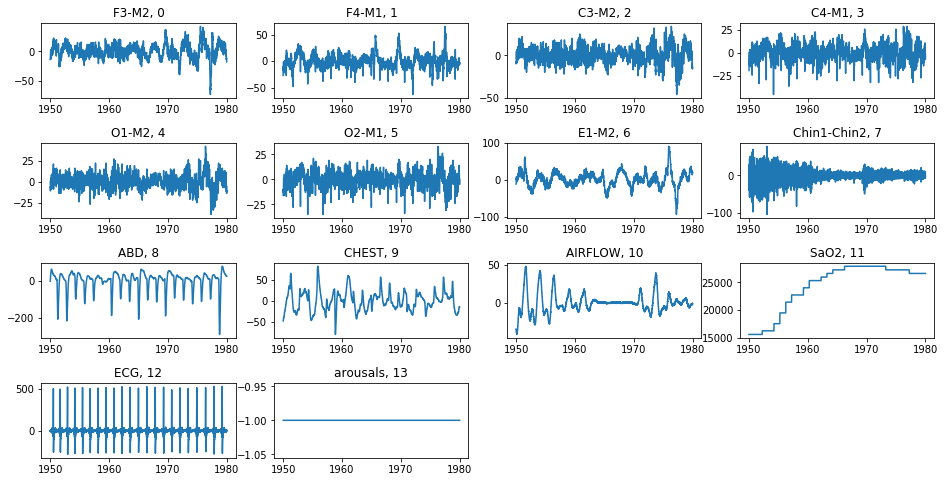

In [7]:
plot_time  = np.arange(0, len(data)/200, 1/200)
fs = 200
start = fs *1950
end = fs * 1980

plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.6)

for i in range(0, len(data.columns), 1):
    plt.subplot(4, 4, (i+1))
    plt.title("{}, {}".format(data.columns[i], i))
    plt.plot(plot_time[start:end], data.iloc[start:end, i])
plt.show()

In [8]:
data1 = sp.stats.zscore(data.iloc[:, 0])
data2 = sp.stats.zscore(data.iloc[:, 2])

data_corr = np.correlate(data1, data2)
data_acf1 = np.correlate(data1, data1)
data_acf2 = np.correlate(data2, data2)
data_corr[0]/np.sqrt((data_acf1[0] * data_acf2[0]))

0.8573058668738346

In [9]:
#lb_test = sm.stats.diagnostic.acorr_ljungbox(data1, lags=1000)

In [10]:
data.columns[0]

'F3-M2'

# MEMO

In [11]:
data.arousals.describe()

count    4.770000e+06
mean    -1.662771e-01
std      4.916367e-01
min     -1.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: arousals, dtype: float64

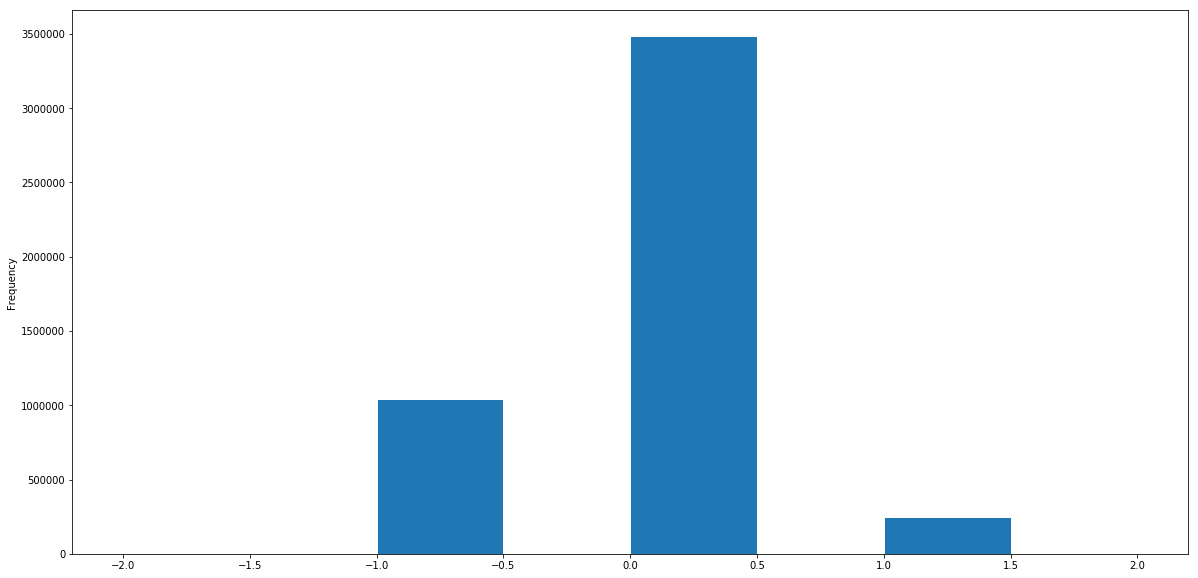

In [12]:
(data['arousals']).plot.hist(bins=8, figsize=(20,10), edgecolor='white',range=[-2,2])

In [13]:
data.arousals.value_counts()/len(data)

 0.0    0.730645
-1.0    0.217816
 1.0    0.051539
Name: arousals, dtype: float64